# Introdução às Redes Convolucionais com PyTorch

Neste notebook, vamos explorar Redes Neurais usando a biblioteca PyTorch. Vamos começar com uma Rede Neural Totalmente Conectada (Fully Connected Network) para classificar dígitos do dataset MNIST. Em seguida, substituiremos a rede por uma Rede Neural Convolucional (CNN) e compararemos os resultados.

## Objetivos
- Carregar e preprocessar o dataset MNIST.
- Implementar uma Rede Neural Totalmente Conectada.
- Treinar e avaliar a rede.
- Substituir a rede por uma CNN e comparar os resultados.

In [65]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
# from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

## Carregando e Preprocessando o Dataset MNIST

O dataset MNIST contém 60.000 imagens de treinamento e 10.000 imagens de teste de dígitos manuscritos, de 0 a 9.

In [66]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-12-16 22:52:46--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv.3’

mnist_train.csv.3   100%[===================>] 104.50M  33.6MB/s    in 3.4s    

2024-12-16 22:52:50 (30.7 MB/s) - ‘data/mnist_train.csv.3’ saved [109575994/109575994]



In [67]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [68]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [69]:
# Criando índices aleatórios para os subsets de treino e teste
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

train_indices = indices[:10000]  # Primeiros 10.000 índices para o trainset
test_indices = indices[10000:11000]  # Próximos 1.000 índices para o testset

trainset = Subset(mnist_dataset, train_indices)
testset = Subset(mnist_dataset, test_indices)

In [70]:
# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

## Visualizando Algumas Imagens do Dataset

Vamos visualizar algumas imagens do dataset de treino para entender melhor os dados com os quais estamos trabalhando.

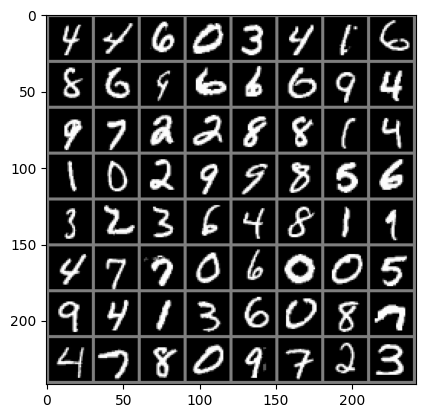

Labels:  4 4 6 0 3 4 1 6


In [71]:
# Função para mostrar uma imagem
def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Obter algumas imagens de treinamento
images, labels = next(iter(trainloader))

# Mostrar imagens
imshow(torchvision.utils.make_grid(images))
# Mostrar labels
print('Labels: ', ' '.join('%d' % labels[j] for j in range(8)))

In [72]:
def train_model(model, trainloader, criterion, optimizer, num_epochs=5):
    train_losses = []
    accuracies = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            # Obter os inputs; data é uma lista de [inputs, labels]
            inputs, labels = data

            # Zerar os gradientes dos parâmetros otimizados
            optimizer.zero_grad()

            # forward + backward + otimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Estatísticas
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 50 == 49:
                train_losses.append(running_loss / 100)
                running_loss = 0.0

        epoch_acc = 100 * correct / total
        accuracies.append(epoch_acc)
        print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.3f}, Accuracy: {epoch_acc:.2f}%')
    print('Treinamento concluído')
    return train_losses, accuracies


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Definindo a Rede Neural Totalmente Conectada

Vamos definir uma arquitetura simples de Rede Neural Totalmente Conectada (FCN).

In [73]:
class FCN(nn.Module):
    def __init__(self, hidden_dim_1=128, hidden_dim_2=64):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

fcn_model = FCN()

In [74]:
fcn_params = count_parameters(fcn_model)
print(f"Total de parâmetros na FCN: {fcn_params}")

Total de parâmetros na FCN: 109386


In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcn_model.parameters(), lr=0.01, momentum=0.9)

In [76]:
# Treinando a FCN
fcn_losses, fcn_accuracies = train_model(fcn_model, trainloader, criterion, optimizer)

100%|██████████| 157/157 [00:08<00:00, 19.34it/s]


Epoch 1, Loss: 0.264, Accuracy: 67.69%


100%|██████████| 157/157 [00:05<00:00, 28.23it/s]


Epoch 2, Loss: 0.179, Accuracy: 87.70%


100%|██████████| 157/157 [00:06<00:00, 23.83it/s]


Epoch 3, Loss: 0.148, Accuracy: 89.79%


100%|██████████| 157/157 [00:05<00:00, 27.75it/s]


Epoch 4, Loss: 0.134, Accuracy: 91.88%


100%|██████████| 157/157 [00:05<00:00, 27.93it/s]

Epoch 5, Loss: 0.111, Accuracy: 92.90%
Treinamento concluído


In [77]:
# Testando a FCN
test_model(fcn_model, testloader)

Acurácia da rede na base de teste: 94.30%


## Substituindo a Rede Neural por uma CNN

Agora, vamos substituir a Rede Neural Totalmente Conectada por uma Rede Neural Convolucional (CNN) e comparar os resultados.

In [78]:
class CNN(nn.Module):
    def __init__(self, num_filters_1=6, num_filters_2=12):
        super(CNN, self).__init__()
        self.num_filters_2 = num_filters_2
        self.conv1 = nn.Conv2d(1, num_filters_1, 5)
        self.conv2 = nn.Conv2d(num_filters_1, num_filters_2, 5)
        self.fc1 = nn.Linear(num_filters_2 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.num_filters_2 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

cnn_model = CNN()

In [79]:
cnn_params = count_parameters(cnn_model)
print(f"Total de parâmetros na CNN: {cnn_params}")

Total de parâmetros na CNN: 14970


In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)

In [81]:
# Treinando a CNN
cnn_losses, cnn_accuracies = train_model(cnn_model, trainloader, criterion, optimizer)

100%|██████████| 157/157 [00:07<00:00, 19.73it/s]


Epoch 1, Loss: 0.239, Accuracy: 56.51%


100%|██████████| 157/157 [00:07<00:00, 21.45it/s]


Epoch 2, Loss: 0.095, Accuracy: 92.91%


100%|██████████| 157/157 [00:07<00:00, 20.61it/s]


Epoch 3, Loss: 0.062, Accuracy: 95.79%


100%|██████████| 157/157 [00:07<00:00, 22.15it/s]


Epoch 4, Loss: 0.051, Accuracy: 97.05%


100%|██████████| 157/157 [00:07<00:00, 20.46it/s]

Epoch 5, Loss: 0.037, Accuracy: 97.58%
Treinamento concluído


In [82]:
# Testando a CNN
test_model(cnn_model, testloader)

Acurácia da rede na base de teste: 95.50%


## Comparando as duas redes neurais

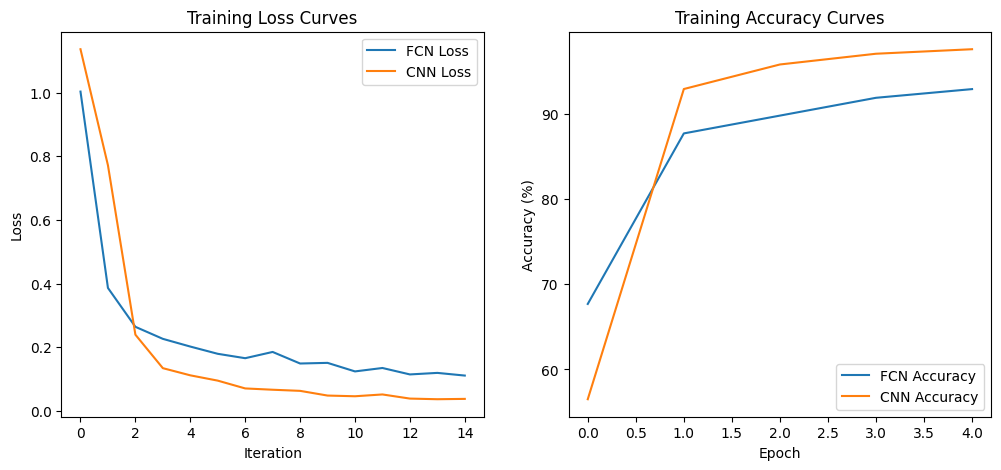

In [83]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fcn_losses, label='FCN Loss')
plt.plot(cnn_losses, label='CNN Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fcn_accuracies, label='FCN Accuracy')
plt.plot(cnn_accuracies, label='CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curves')
plt.legend()

plt.show()

## Exercícios

### Exercício 1
Altere a estrutura da rede e diminua o número de parâmetros na rede FC. O que se observa no resultado do treinamento?

In [84]:
fcn_model_ex1 = FCN(hidden_dim_1=64, hidden_dim_2=32)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcn_model_ex1.parameters(), lr=0.01, momentum=0.9)

fcn_losses, fcn_accuracies = train_model(fcn_model_ex1, trainloader, criterion, optimizer, num_epochs=2)

test_model(fcn_model_ex1, testloader)

100%|██████████| 157/157 [00:05<00:00, 27.75it/s]


Epoch 1, Loss: 0.276, Accuracy: 65.63%


100%|██████████| 157/157 [00:06<00:00, 24.59it/s]


Epoch 2, Loss: 0.202, Accuracy: 87.46%
Treinamento concluído
Acurácia da rede na base de teste: 90.90%


### Exercício 2
Aumente o número de filtros convolucionais na CNN. O que se observa no resultado do treinamento em comparação ao anterior? Lembre-se de ajustar os valores das camadas seguintes.

In [85]:
cnn_model_ex2 = CNN(num_filters_1=12, num_filters_2=24)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model_ex2.parameters(), lr=0.01, momentum=0.9)

cnn_losses, cnn_accuracies = train_model(cnn_model_ex2, trainloader, criterion, optimizer)

test_model(cnn_model_ex2, testloader)

100%|██████████| 157/157 [00:08<00:00, 18.58it/s]


Epoch 1, Loss: 0.195, Accuracy: 63.73%


100%|██████████| 157/157 [00:09<00:00, 17.28it/s]


Epoch 2, Loss: 0.080, Accuracy: 93.83%


100%|██████████| 157/157 [00:09<00:00, 15.99it/s]


Epoch 3, Loss: 0.047, Accuracy: 96.43%


100%|██████████| 157/157 [00:07<00:00, 19.67it/s]


Epoch 4, Loss: 0.053, Accuracy: 97.18%


100%|██████████| 157/157 [00:09<00:00, 16.29it/s]


Epoch 5, Loss: 0.034, Accuracy: 97.79%
Treinamento concluído
Acurácia da rede na base de teste: 97.10%
